In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

### Parameters

In [23]:
iteration = 2
PhenoGraph_k =  30
size_smallest_cluster = 20
survival_type = 'Overall'
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k':30
}


# Cohort 1

### Load Gram matrix and clinical data

In [24]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
print(np.percentile(Gram_matrix, 50), np.percentile(Gram_matrix, 75), np.percentile(Gram_matrix, 90), np.percentile(Gram_matrix, 95), np.percentile(Gram_matrix, 99))
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

0.0940820569110426 0.25173937495043835 0.4529840069200116 0.583059924628228 0.8345873758043105


### Community detection

In [25]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster)

### Survival analysis for subgroups

In [26]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relapse-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{}:".format(HR[i]['subgroup_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

S1:
Survival: hr = 1.8730941299662691, p = 0.02022542832414342
S2:
Survival: hr = 1.8463434703115895, p = 0.028367201607763397
S3:
Survival: hr = 1.338894007817867, p = 0.2949374367635713
S4:
Survival: hr = 1.2401991324598083, p = 0.3544630346703699
S5:
Survival: hr = 0.9609233134134707, p = 0.838316588426957
S6:
Survival: hr = 0.7911320858725324, p = 0.3343250540934516
S7:
Survival: hr = 0.6329691566893938, p = 0.0370916603275056
S8:
Survival: hr = 0.4078186126771445, p = 0.005876492754923817


### Plot hazard ratio

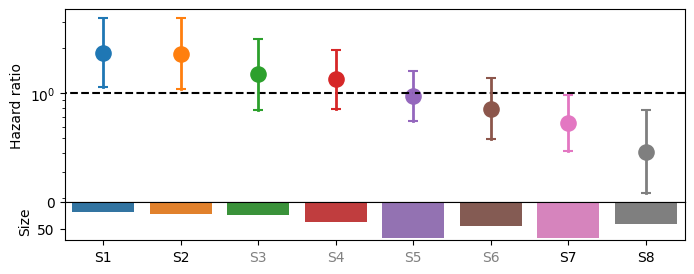

In [27]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Find Over-presented Patterns

In [28]:
Candidates = []
Candiates_overpresented_in_subgroup = []
from scipy import stats
for hr_dict in HR:
    subgroup_id = hr_dict["subgroup_id"]
    hr = hr_dict["hr"]
    p = hr_dict["p"]
    if p < 0.05:
        Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
        Histogram_out_group = Histograms_[Subgroup_ids_ != subgroup_id]
        for i in range(Histograms_.shape[1]):
            rvsi = Histogram_intra_group[:, i]
            rvso = Histogram_out_group[:, i]
            ratio = np.mean(rvsi) / np.mean(rvso)
            result = stats.ttest_ind(rvsi, rvso, equal_var=False)
            if (result.pvalue < 0.05/Histograms_.shape[1]) and (ratio > 2):
                print(
                        "Pattern {} overpresented in {} by {:.3f} times (p={:.5f})".format(
                            i,subgroup_id,  ratio, result.pvalue
                        )
                    )
                Candidates.append(i)
                Candiates_overpresented_in_subgroup.append(subgroup_id)
                
                    
print(Candidates)              
print(Candiates_overpresented_in_subgroup)



Pattern 37 overpresented in 2 by 158.026 times (p=0.00001)
Pattern 59 overpresented in 2 by 89.437 times (p=0.00001)
Pattern 84 overpresented in 2 by 145.018 times (p=0.00006)
Pattern 5 overpresented in 7 by 6.192 times (p=0.00000)
Pattern 13 overpresented in 7 by 16.618 times (p=0.00000)
Pattern 15 overpresented in 7 by 2.043 times (p=0.00008)
Pattern 17 overpresented in 7 by 6.889 times (p=0.00007)
Pattern 21 overpresented in 7 by 3.243 times (p=0.00000)
Pattern 22 overpresented in 7 by 6.497 times (p=0.00030)
Pattern 24 overpresented in 7 by 5.208 times (p=0.00014)
Pattern 29 overpresented in 7 by 27.817 times (p=0.00003)
Pattern 36 overpresented in 7 by 20.893 times (p=0.00000)
Pattern 39 overpresented in 7 by 8.650 times (p=0.00001)
Pattern 40 overpresented in 7 by 3.524 times (p=0.00008)
Pattern 44 overpresented in 7 by 6.423 times (p=0.00037)
Pattern 47 overpresented in 7 by 8.727 times (p=0.00022)
Pattern 20 overpresented in 8 by 5.197 times (p=0.00002)
Pattern 71 overpresented

### Test these over-presented patterns

Pattern = 5, p-value = 0.0005687
Pattern = 17, p-value = 0.0019306
Pattern = 24, p-value = 0.0000056
Pattern = 29, p-value = 0.0002308
Pattern = 36, p-value = 0.0008780
Pattern = 39, p-value = 0.0000100
Pattern = 44, p-value = 0.0024983
Pattern = 47, p-value = 0.0001112
Pattern = 20, p-value = 0.0003512
[5, 17, 24, 29, 36, 39, 44, 47, 20]


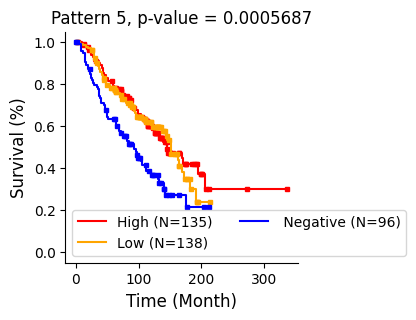

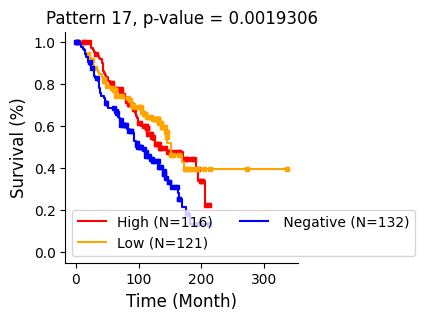

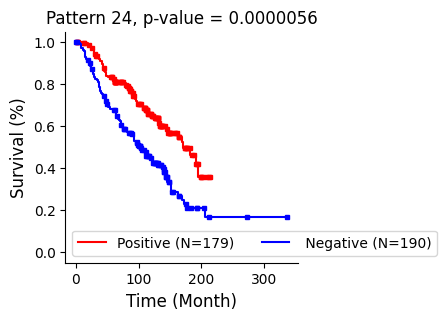

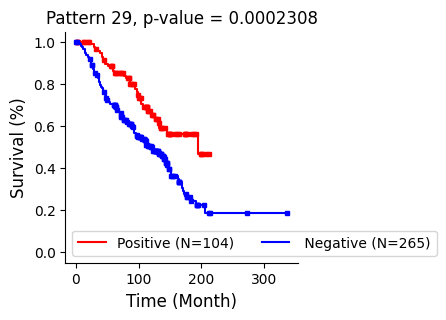

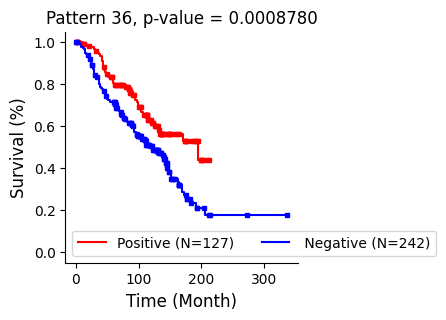

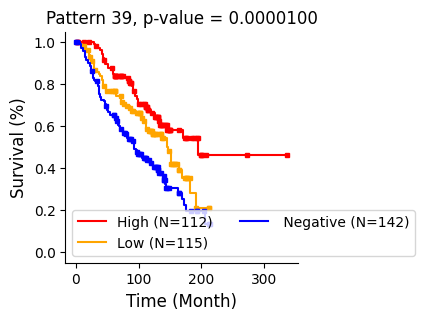

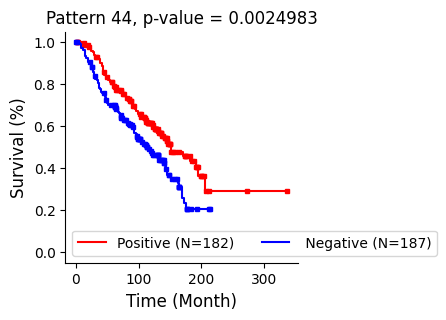

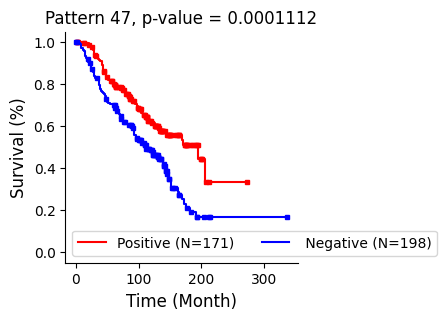

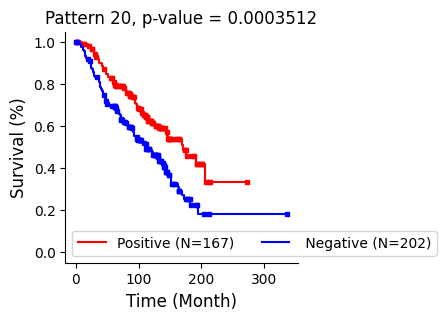

In [29]:
kmf = KaplanMeierFitter()
Candidates_1 = []
for pattern_id in Candidates:
    histogram_pattern = Histograms_[:, pattern_id]
    if np.percentile(histogram_pattern, 50) == 0:
        length_A, event_observed_A = (
            Length_[histogram_pattern > 0],
            Status_[histogram_pattern > 0],
        )
        length_B, event_observed_B = (
            Length_[histogram_pattern == 0],
            Status_[histogram_pattern == 0],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        
        if p_value <0.05/len(Candidates):
            print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
            Candidates_1.append(pattern_id)
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_[histogram_pattern > threshold],
            Status_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_[histogram_pattern == 0],
            Status_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        if p_value < 0.05/len(Candidates) :
            print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
            Candidates_1.append(pattern_id)
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
print(Candidates_1)

# Cohort 2

In [149]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
if survival_type == 'Overall':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs_cohort2]  
elif survival_type == 'Relpase-free':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs_cohort2] 
elif survival_type == 'Disease-specific':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs_cohort2]
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

In [150]:
kmf = KaplanMeierFitter()
for pattern_id in Candidates_1:
    histogram_pattern = Histograms_cohort2_[:, pattern_id]
    if np.percentile(histogram_pattern, 50) == 0:
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > 0],
            Status_cohort2_[histogram_pattern > 0],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern == 0],
            Status_cohort2_[histogram_pattern == 0],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1):
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > threshold],
            Status_cohort2_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern == 0],
            Status_cohort2_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1) :
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()

Pattern = 5, p-value = 0.0715125
Pattern = 17, p-value = 0.1730540
Pattern = 24, p-value = 0.3131773
Pattern = 29, p-value = 0.4462192
Pattern = 36, p-value = 0.1595136
Pattern = 39, p-value = 0.1680422
Pattern = 44, p-value = 0.0729120
Pattern = 47, p-value = 0.8042818
Pattern = 20, p-value = 0.5668608


# Jackson

In [151]:
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})


if survival_type == "Overall":
    Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]
elif survival_type == "Relpase-free":
    Length_jackson = [
        clinical.loc[
            clinical["patient_id"] == i, "Relapse Free Status (Months)"
        ].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Relapse Free Status"].values[0]
        for i in Patient_IDs_jackson
    ]
DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]

Pattern = 5, p-value = 0.0009168
Pattern = 17, p-value = 0.0764824
Pattern = 24, p-value = 0.0743435
Pattern = 29, p-value = 0.0210787
Pattern = 36, p-value = 0.0605802
Pattern = 39, p-value = 0.0042029
Pattern = 44, p-value = 0.7305404
Pattern = 47, p-value = 0.0233238
Pattern = 20, p-value = 0.0027199


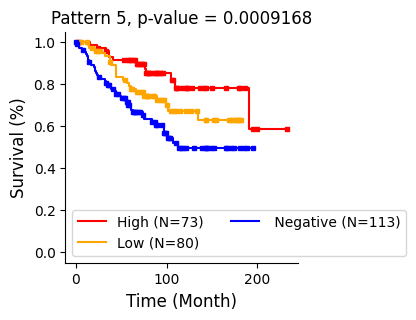

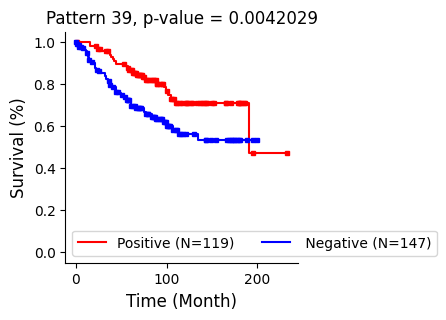

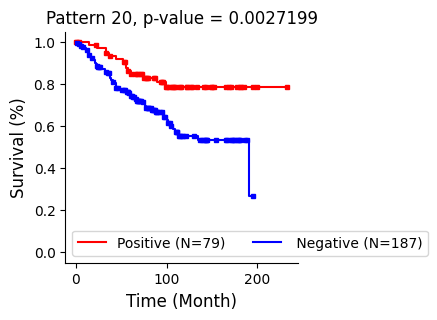

In [152]:
kmf = KaplanMeierFitter()
for pattern_id in Candidates_1:
    histogram_pattern = Histograms_jackson_[:, pattern_id]
    if np.percentile(histogram_pattern, 50) == 0:
        length_A, event_observed_A = (
            Length_jackson_[histogram_pattern > 0],
            Status_jackson_[histogram_pattern > 0],
        )
        length_B, event_observed_B = (
            Length_jackson_[histogram_pattern == 0],
            Status_jackson_[histogram_pattern == 0],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1):
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_jackson_[histogram_pattern > threshold],
            Status_jackson_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_jackson_[histogram_pattern == 0],
            Status_jackson_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_jackson_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_jackson_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1) :
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()

# Other (probably) useful information

### KM-Plots

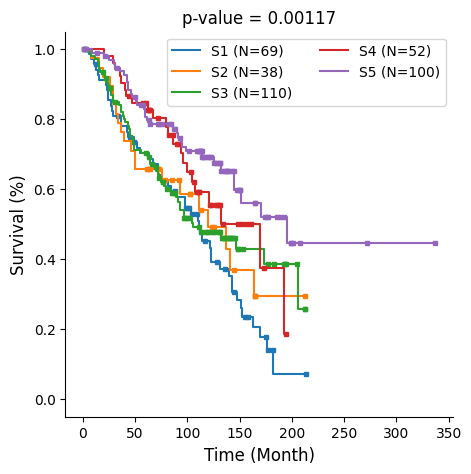

In [48]:

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

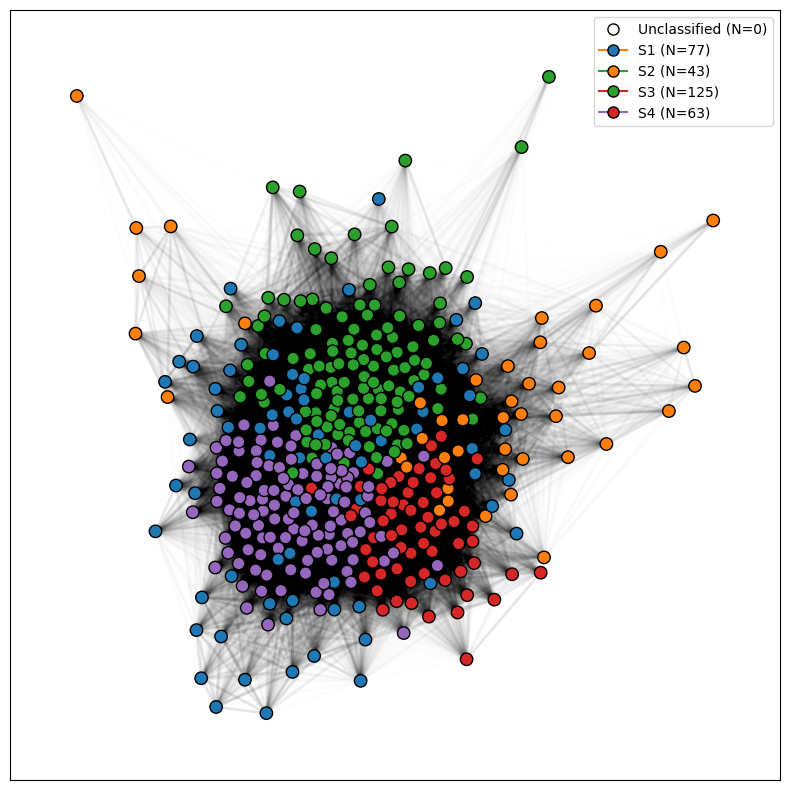

In [682]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

In [521]:
# Histograms_ = (Histograms_ - np.mean(Histograms_, axis=0))/np.std(Histograms_, axis=0)
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
for pattern_id in Candidates:
    DF["pattern_"+str(pattern_id)] = Histograms_[:, pattern_id]
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in Candidates]))
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 369 total observations, 189 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 369
number of events observed = 180
   partial log-likelihood = -938.75
         time fit was run = 2023-11-03 01:07:38 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
pattern_10  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_15  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_16   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_18   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_22  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
pattern_23  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
pattern_28   0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
pattern_35  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00

             cmp to     z    p   -log2(p)
covariate                                
pattern_10     0.00 -0.16 0.88       0.19
pattern_15     0.00 -0.92 0.36       1.49
pattern_16     0.00  1.60 0.11       3.20
pattern_18     0.00  0.48 0.63       0.66
pattern_22     0.00 -1.67 0.09       3.40
pattern_23     0.00 -2.08 0.04       4.74
pattern_28     0.00  2.67 0.01       7.04
pattern_35     0.00 -1.84 0.07       3.92
---
Concordance = 0.59
Partial AIC = 1893.49
log-likelihood ratio test = 19.64 on 8 df
-log2(p) of ll-ratio test = 6.41

None
